<a href="https://colab.research.google.com/github/nidaa-hub/HaifaUniv_AI_Lab_2022/blob/main/AI_2022_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***README***

to run this program:

1.   Press ▶ or ctrl+Enter

2. upload the .txt files for input to the collab session storage. (note that the files in collab get deleted after the session ends)

3. whan running the cose we get input box and we need to enter the path of the input file inside the box.

* to get the path right press the cruser on the input file and choose "Copy path" then past it inside the input box.

4. Enter the selected algorithm (Simulated Annealing = 1, Tabu Search = 2, ACO = 3, Genetic = 4, PSO = 5)

*   ID Submetter1: 316151232
*   ID Submetter2: 038163630

Enter input path: /content/example.txt
CRVP solver
Select one of the following algorithms:
Simulated Annealing = 1, Tabu Search = 2, ACO = 3, Genetic = 4, PSO = 5
2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:474: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:476: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Current best state cost:  80.6449510224598 Clock ticks:  0.01436999999999955
cost 80.6449510224598
Total elapsed time:  0.018541574478149414
Solution cost:  80.6449510224598
0 2 3 4 0
0 1 0


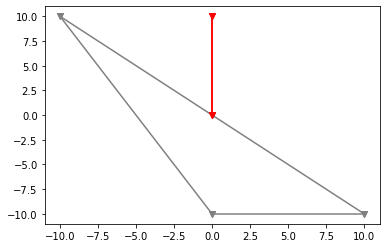

Click enter to exit


''

In [ ]:
from functools import reduce
import numpy as np
import time
from numpy.random import choice
import csv
import re
import matplotlib.pyplot as plt
from __future__ import division
from random import randint, random, sample, shuffle
import operator
import copy
import random
from random import uniform

GA_ELITRATE = 0.4
maxIterations = 16384
populationSize = 2048
GA_MUTATIONRATE = 0.3
GA_TARGET = "Hello World!"
nCitits = 0
initPoint,capacity, graph, demand, optimalValue, ncars = None,None,None,None,None,None
alpha = 2
beta = 5
sigma = 3
ro = 0.8
theta = 80

class Agent:
    def __init__(self, string, fitness):
        self.string = string
        self.fitness = fitness
        self.age = 0
        self.cars = 0

class PSO:

    def __init__(self, graph, demand, capacity, initPoint):
        self.particles = []
        self.graph = graph
        self.globalBest = None
        self.globalBestFitness = float('inf')
        self.tsize = len(GA_TARGET)
        self.initParticles()
        self.C1 = 1
        self.C2 = 3
        self.W = 1
        self.capacity = capacity
        self.demand = demand
        self.initPoint = initPoint
        self.feromones, self.distances = self.createFeromonListAndDistanceList()

    def run(self):
        target = [ord(char) for char in GA_TARGET]
        found = False
        for t in range(maxIterations):
            for particle in self.particles:
                particle.update(self.globalBest, self.C1, self.C2, self.W)
                fitness = self.calcFitness(particle.getString())
                particle.setFitness(fitness)
                self.updateGPBest(particle, fitness)
            self.sortByFitness()
            self.updateParameters(t, maxIterations)
            if self.globalBestFitness == 0:
                print('the best is: ', self.globalBest, '(', self.globalBestFitness, ')')
                print('found.')
                found = True
                break
          
            print('the best is', self.globalBest, '(', self.globalBestFitness, ')')
        if not found:
            print('reached local optimum.')

    def updateParameters(self, t, N):   # update the PSO parameters
        self.W = 0.4 * ((t - N) / N ** 2) + 0.4
        self.C1 = -3 * (t / N) + 3.5
        self.C2 = 3 * (t / N) + 0.5

    def updateGPBest(self, particle, fitness):
        if particle.getBestFitness() > fitness:
            particle.setBestString(particle.getString())
            particle.setBestFitness(fitness)
        if self.globalBestFitness > fitness:
            self.globalBest = particle.getString()
            self.globalBestFitness = fitness

    def initParticles(self):
        for _ in range(populationSize):
            randomPos = []
            randomVector = []
            for _ in range(self.tsize):
                x = randint(32, 126)
                randomPos.append(x)
                y = randint(32, 126)
                randomVector.append(y)
            # save the best string to be the GlobalBest
            if self.globalBest is None:
                self.globalBest = randomPos[0:]
            elif self.calcFitness(randomPos) < self.calcFitness(self.globalBest):
                self.globalBest = randomPos
            particle = Particle(randomPos, self.calcFitness(randomPos), randomVector)
            self.particles.append(particle)

    def calcFitness(self, particle):
        target = [ord(char) for char in GA_TARGET]
        fitness = 0
        for j in range(0, self.tsize):
            fitness += (abs(particle[j] - target[j]))
        return fitness

    def sortByFitness(self):
        self.particles.sort()
        self.globalBest = self.particles[0].getString()
        self.globalBestFitness = self.particles[0].getFitness()

    def getEdge(self,v1,v2):
        return min(v1,v2), max(v1,v2)

    def createFeromonListAndDistanceList(self):
      feromonesList, distances = dict(), dict()
      for vertics1 in self.graph.keys():
          for vertics2 in self.graph.keys():
              first, second = self.getEdge(vertics1,vertics2)
              if vertics1 != vertics2:                    
                  feromonesList[(first, second)] = 1
              distances[(first, second)] = getDistance(self.graph[first],self.graph[second])
      return feromonesList, distances

#added here: 
    #create route and calculate its cost
    def getNewState(self):
        routes, cities = [], [i for i in self.graph.keys()]
              
        
        while len(cities) != 0:
            
            currCapacity = self.capacity
            city = choice(cities, 1)[0]
            currentTruckPath = [city]
            currCapacity -= self.demand[city]
            cities.remove(city)

            #find cities to routes per truck
            finish = False
            while len(cities) != 0 and finish == False:
                probs = self.getProbs(city, cities)
                city = choice(cities, 1, p=probs)[0]
                if currCapacity - self.demand[city] >= 0:
                    currentTruckPath.append(city)
                    cities.remove(city)
                    currCapacity -= self.demand[city]
                else:finish = True
            routes.append(currentTruckPath)
                                                                                                               
        routesCost = calculateDistance(self.graph, routes,self.initPoint)
        print('cost: ' ,routesCost)
        return (routes, routesCost)  

      
    def getProbs(self,city, cities):
        probs = []
        for c in cities:
            first, second = self.getEdge(c,city)
            p = ((self.feromones[(first, second)])**alpha)*((1/self.distances[(first, second)])**beta)
            probs.append(p)

        return probs/np.sum(probs) 

class Particle:
    def __init__(self, string, fitness, velocityVector):
        self.string = string
        self.bestString = string
        self.fitness = fitness
        self.bestFitness = fitness
        self.velocityVector = velocityVector

    def getString(self):
        return self.string

    def getBestString(self):
        return self.bestString

    def getFitness(self):
        return self.fitness

    def getBestFitness(self):
        return self.bestFitness

    def setString(self, string):
        self.string = string

    def setBestString(self, bestString):
        self.bestString = bestString

    def setFitness(self, fitness):
        self.fitness = fitness

    def setBestFitness(self, bestFitness):
        self.bestFitness = bestFitness

    def update(self, Gbest, C1, C2, W):
        r1 = uniform(0, 1)
        r2 = uniform(0, 1)

        new_string1 = self.newString(self.getBestString(), self.getString(), r1 * C1)
        new_string2 = self.newString(Gbest, self.getString(), r2 * C2)
        add_String = self.addString(new_string2, new_string1)
        self.velocityVector = [(self.velocityVector[i] * W) for i in range(len(self.velocityVector))]

        self.velocityVector = self.addString(self.velocityVector, add_String)
        self.string = self.addString(self.string, self.velocityVector)

        self.string = [round(self.string[i]) for i in range(len(self.string))]
        self.velocityVector = [round(self.velocityVector[i]) for i in range(len(self.velocityVector))]

    def addString(self, str1, str2):
        new_string = []
        for i in range(len(str1)):
            new_string.append((str1[i]) + (str2[i]))
        return new_string

    def newString(self, str1, str2, x):
        new_string = []
        for i in range(len(str1)):
            new_string.append((x * ((str1[i]) - (str2[i]))))
        return new_string

    def __gt__(self, other):
        return self.getFitness() >= other.getFitness()

    def __lt__(self, other):
        return self.getFitness() < other.getFitness()

class simulatedAnnealing:
    def __init__(self, initialState, graph, demand, capacity, initPoint,
                  optimalValue, ncars, initTemp, maxIter, nAttemps):
        self.state = initialState
        self.graph = graph
        self.demand = demand
        self.capacity = capacity
        self.initPoint = initPoint
        self.optimalValue = optimalValue
        self.ncars = ncars
        self.initTemp = initTemp
        self.maxIter = maxIter
        self.nAttemps = nAttemps
        self.valueMaxRep = self.nAttemps*5

    def updateTemp(self,temp):
      return random.uniform(0, 1) * temp
  
    def simulate(self):
      totalTime = time.time()
      startTime = time.clock()
      temp = self.initTemp
      currState, bestState = self.state, [i for i in self.state]
      valueMaxTries = self.valueMaxRep
      bestCostRep = 0
      for iteration in range(self.maxIter):
          for j in range(self.nAttemps):
              i1, i2 = getTwoIndexesFromState(currState)
              
              nextState = swap(currState, i1, i2)
              
              currCost, nextCost = calculateSolDistance(self.initPoint, currState, self.graph, self.capacity, self.demand, self.ncars),calculateSolDistance(self.initPoint, nextState, self.graph, self.capacity, self.demand, self.ncars)
              cost_diff = nextCost - currCost
  
              
              if cost_diff < 0:
                  currState = [i for i in nextState]
                  bestCost = calculateSolDistance(self.initPoint, bestState, self.graph, self.capacity, self.demand, self.ncars)
                  currCost = calculateSolDistance(self.initPoint, currState, self.graph, self.capacity, self.demand, self.ncars)
                  if currCost < bestCost:
                      bestState =  [i for i in currState]
              else:
                  try:
                      ans = np.exp(-cost_diff / temp)
  
                  except OverflowError:
                      ans = float('inf')
                  if random.uniform(0, 1) < ans:
                      currState = [i for i in nextState]
          

          bestCost = calculateSolDistance(self.initPoint, bestState, self.graph, self.capacity, self.demand, self.ncars)
          print("Current best state cost: ",str(bestCost),"Clock ticks: ",str(time.clock() - startTime))
          startTime = time.clock()
          if bestCostRep != bestCost and int(bestCost) != int(self.optimalValue) and time.time() - totalTime < self.ncars * 0.6:
              bestCostRep = bestCost
              valueMaxTries = self.valueMaxRep
          else:
              valueMaxTries -= 1
              if valueMaxTries == 0 or int(bestCost) == int(self.optimalValue) or time.time() - totalTime >= self.ncars * 0.6:
                  tour = creatTrucksTour(bestState, self.graph, self.capacity, self.demand, self.ncars)
                  return tour, bestCost, self.initPoint, iteration
                    
              
          
          temp = temp * 0.95
      bestCost = calculateSolDistance(self.initPoint, bestState, self.graph, self.capacity, self.demand, self.ncars)
      return bestState, bestCost, self.initPoint    

class ACO:
    def __init__(self,graph, demand, capacity, initPoint,
                  optimalValue, ncars, maxIter, maxTries, antsNumber):
        self.graph = graph
        self.demand = demand
        self.capacity = capacity
        self.initPoint = initPoint
        self.optimalValue = optimalValue
        self.ncars = ncars
        self.maxIter = maxIter
        self.limitTime = 0.6 * ncars
        self.maxTries = maxTries
        self.antsNumber = antsNumber
        self.feromones, self.distances = self.createFeromonListAndDistanceList()
    def getEdge(self,v1,v2):
        return min(v1,v2), max(v1,v2)
    
    def createFeromonListAndDistanceList(self):
        feromonesList, distances = dict(), dict()
        for vertics1 in self.graph.keys():
            for vertics2 in self.graph.keys():
                first, second = self.getEdge(vertics1,vertics2)
                if vertics1 != vertics2:                    
                    feromonesList[(first, second)] = 1
                distances[(first, second)] = getDistance(self.graph[first],self.graph[second])
        return feromonesList, distances
    
    def getProbs(self,city, cities ):
        probs = []
        for c in cities:
            first, second = self.getEdge(c,city)
            p = ((self.feromones[(first, second)])**alpha)*((1/self.distances[(first, second)])**beta)
            probs.append(p)

        return probs/np.sum(probs)
    
    
    
    #create route and calculate its cost
    def getNewState(self):
        routes, cities = [], [i for i in self.graph.keys()]
        
        
        while len(cities) != 0:
            
            currCapacity = self.capacity
            city = choice(cities, 1)[0]
            currentTruckPath = [city]
            currCapacity -= self.demand[city]
            cities.remove(city)

            #find cities to routes per truck
            finish = False
            while len(cities) != 0 and finish == False:
                probs = self.getProbs(city, cities)
                city = choice(cities, 1, p=probs)[0]
                if currCapacity - self.demand[city] >= 0:
                    currentTruckPath.append(city)
                    cities.remove(city)
                    currCapacity -= self.demand[city]
                else:finish = True
            routes.append(currentTruckPath)
                                                                                                               
        routesCost = calculateDistance(self.graph, routes,self.initPoint)
        
        return (routes, routesCost)
    
    
    def getBestAndUpdateferm(self, feromones, antsSol, bestState):
        avg = 0
        for el in antsSol:
            avg+=el[1]
        avg = avg/len(antsSol)
        for key in self.feromones.keys():
            self.feromones[key] = (ro + theta/avg)*self.feromones[key]
        antsSol.sort(key = lambda sol: sol[1])
        if(bestState==None):
            bestState = antsSol[0]
        else:
            if(antsSol[0][1] < bestState[1]):
                bestState = antsSol[0]
            for path in bestState[0]:
                for i in range(len(path)-1):
                    v1, v2 = self.getEdge(path[i],path[i+1])
                    self.feromones[(v1,v2)] = sigma/bestState[1] + self.feromones[(v1,v2)]
            
        for idx in range(sigma):
            routes, routesCost = antsSol[idx][0], antsSol[idx][1]
            for truck in routes:
                for i in range(len(truck)-1):
                    v1, v2 = self.getEdge(truck[i],truck[i+1])
                    self.feromones[(v1,v2)] = (sigma-(idx+1)/routesCost**(idx+1)) + self.feromones[(v1,v2)]
        return bestState
    
    def checkIterStopCond(self,startTime,iteration):
        if iteration > self.maxIter or (time.time() - startTime) > self.limitTime:
            return False
        else:
            return True
            
    def runAnts(self):     
        startTimeClock = time.clock()
        startTime = time.time()
        bestState, iteration = None, 0
        tryMax = self.maxTries
        while self.checkIterStopCond(startTime,iteration):
            antsSolutions = [ self.getNewState() for i in range(self.antsNumber)]
            newBest = self.getBestAndUpdateferm(self.feromones, antsSolutions, bestState)
            if bestState!= None:
                if newBest[1]<bestState[1]:
                    tryMax = self.maxTries
                    bestState = newBest
                else:
                    tryMax -= 1
                    if tryMax == 0:
                        break
            else:
                bestState = newBest
            print("Current best state cost: ",str(bestState[1]), "Clock ticks: ",str(time.clock() - startTimeClock),"Iteration: ",iteration)
            startTimeClock = time.clock()
            iteration += 1
        return bestState,time.time() - startTime,iteration
class tabuSearch:
    def __init__(self, initialState, graph, demand, capacity, initPoint,
                  optimalValue, ncars, maxIter, nNeighbors, maxTabuSize, nAttemps):
        self.state = initialState
        self.graph = graph
        self.demand = demand
        self.capacity = capacity
        self.initPoint = initPoint
        self.ncars = ncars
        self.maxIter = maxIter
        self.optimalValue = optimalValue
        self.tabuList = []
        self.nNeighbors = nNeighbors
        self.maxTabuSize = maxTabuSize
        self.nAttemps = nAttemps
        self.valueMaxRep = self.nAttemps*5
        
    def getFitness(self, state):
        return calculateSolDistance(self.initPoint, state, self.graph, self.capacity, self.demand, self.ncars)

    
    def run(self):
        startTime = time.clock()
        totalTime = time.time()
        sBest  = self.state
        bestCostRep = 0
        bestCandidate = [i for i in sBest]
        self.tabuList.append([i for i in sBest])
        valueMaxTries = self.valueMaxRep
        for iteration in range(self.maxIter):
            #create n neighbors to take the best
            neighbors = []
            for i in range(self.nNeighbors):
                i1, i2 = getTwoIndexesFromState(bestCandidate)                
                newNeighbor = swap(bestCandidate, i1, i2)
                neighbors.append(newNeighbor)
                
            bestCandidate = neighbors[0]
            for sCandidate in neighbors:
                if ( (sCandidate not in self.tabuList) and (self.getFitness(sCandidate) < self.getFitness(bestCandidate)) ):
                    bestCandidate = sCandidate
            
            if (self.getFitness(bestCandidate) < self.getFitness(sBest)):
                sBest = [i for i in bestCandidate]
                
            self.tabuList.append([i for i in bestCandidate])
            if len(self.tabuList) > self.maxTabuSize:
                self.tabuList = self.tabuList[50:]#self.tabuList[int(self.maxTabuSize/2):]
            
            bestCost = self.getFitness(sBest)
            print("Current best state cost: ",str(bestCost), "Clock ticks: ",str(time.clock() - startTime)
            startTime = time.clock()
            if int(bestCostRep) != int(bestCost) and int(bestCost) != int(self.optimalValue)  and time.time() - totalTime < self.ncars * 0.8:
                bestCostRep = bestCost
                valueMaxTries = self.valueMaxRep
            else:
                valueMaxTries -= 1
                if valueMaxTries == 0 or int(bestCost) == int(self.optimalValue) or time.time() - totalTime >= self.ncars * 0.8:
                    tour = creatTrucksTour(sBest, self.graph, self.capacity, self.demand, self.ncars)
                    return tour, bestCost, self.initPoint, iteration
                      
        tour = creatTrucksTour(sBest, self.graph, self.capacity, self.demand, self.ncars)
        bestCost = self.getFitness(sBest)
        return tour, bestCost, self.initPoint

def solve(algorithm, path):
    startTime = time.time()
    bestState, bestCost, initPoint = None, None, None
    initPoint,capacity, graph, demand, optimalValue, ncars, problemName = getData(path)
    initState = createShuffledState(graph.keys())
    if algorithm == 0:
        #SA
        alg = simulatedAnnealing(initState,graph, demand,capacity,initPoint,optimalValue, ncars
                         ,2000,2000000,30)
        bestState, bestCost, initPoint, iteration = alg.simulate()
        
    elif algorithm == 1:
        #tabu
        alg = tabuSearch(initState,graph, demand,capacity,initPoint,optimalValue, ncars
                         ,2000000,100, 300,30)
        bestState, bestCost, initPoint, iteration =  alg.run()
    elif algorithm == 2:
        alg = ACO(graph, demand, capacity, initPoint,optimalValue, ncars, 100000, 70,23)
        best, runtime, iteration = alg.runAnts()
        bestState, bestCost = best[0], best[1]
    elif algorithm == 3:
        bestState, bestCost, iteration = startGenetic(path)
    elif algorithm == 4:
        pso = PSO(graph, demand, capacity, initPoint)
        bestState, bestCost =pso.getNewState()
        pso.run()
           
        
    print("Total elapsed time: ",str(time.time() - startTime))
    prinSolution(bestState, bestCost,graph, initPoint)


def getData(fileName):
    
    f = open(fileName, "r")
    content = f.read()
    problemName = content.split("COMMENT")[0].split(" : ")[1].replace('\n','')
    cords = content.split("NODE_COORD_SECTION")[1].split("\n")
    i=1
    graph = {}
    for c in cords:
        if c!="" and c!="DEMAND_SECTION":
            c = c.split(" ")
            
            graph[i] = (int(c[1]), int(c[2]))
            i += 1
        if  c=="DEMAND_SECTION":
            break
            
    optimalValue = re.search("Optimal value: (\d+)", content, re.MULTILINE)
    if(optimalValue != None):
        optimalValue = optimalValue.group(1)
    else:
        optimalValue = re.search("Best value: (\d+)", content, re.MULTILINE)
        if(optimalValue != None):
            optimalValue = optimalValue.group(1)
    capacity = re.search("^CAPACITY : (\d+)$", content, re.MULTILINE).group(1)

    demand = re.findall(r"^(\d+) (\d+)$", content, re.MULTILINE)
    demand = {int(a):int(b) for a,b in demand}
    capacity = int(capacity)
    optimalValue = int(optimalValue)
    ncars = int(re.search("^DIMENSION : (\d+)$", content, re.MULTILINE).group(1))
    initPoint = graph[list(graph.keys())[0]]
###################################################
    #first point is the ware house, so remove it
    newGraph = dict()
    newDemand = dict()
    for key in graph.keys():
        if key != 1:
            newGraph[key-1] = graph[key]
    for key in demand.keys():
        if key != 1:
            newDemand[key-1] = demand[key]
    graph = newGraph
    demand = newDemand
###################################################    
    return initPoint,capacity, graph, demand, optimalValue, ncars, problemName




def getDistance(p1,p2):
    return np.linalg.norm(np.array(p2)-np.array(p1))
    return  math.sqrt((p2[0]- p1[0])**2 + (p2[1] - p1[1])**2)


def createShuffledState(state):
    newState = list([int(i) for i in state])
    shuffle(newState)
    return newState
    
def generateFirstState(graph,initPoint,demand):
    firstState = list([int(i) for i in graph.keys()])
    firstState.sort(key= lambda x: getDistance(graph[x],initPoint))  # sort population array by fitness
    firstState.reverse()
    return firstState
#create from the state a tours for each truk
def creatTrucksTour(state, graph, capacity, demand, nTrucks):
    trucks = 0
    currCap = capacity
    allTours = [[]]
    for city in state:
        cityDemand = demand[city]   
        if currCap >= cityDemand:
            currCap -= cityDemand
            allTours[len(allTours)-1].append(city)
        else:
            currCap = capacity - cityDemand
            allTours.append([city])
            trucks += 1
            
            if trucks > nTrucks:
                break
    return allTours


def calculateDistance(graph, tours,initPoint):
    distances = 0
    for tour in tours:
        prev = initPoint
        for city in tour:
            cityCord = graph[city]
            distances += getDistance(prev, cityCord)
            prev = cityCord
        distances += getDistance(prev,initPoint)
    return distances

def getTwoIndexesFromState(state):
    i1,i2 = -1, -1
    while True:
        i1 = randint(0, len(state) - 1)
        i2 = randint(0, len(state) - 1)
        if i1 != i2:
            return i1, i2
def swap(state, i1, i2):
    copyState = [i for i in state]
    copyState[i1], copyState[i2] = copyState[i2], copyState[i1]
    return copyState
    
def calculateSolDistance(initPoint, state, graph, capacity, demand, nTrucks):
     tours = creatTrucksTour(state, graph, capacity, demand, nTrucks)
     return calculateDistance(graph, tours,initPoint)

def drawSol(tours, graph, initPoint):
    colors = ["grey","red","blue","green","orange","yellow"]
    c = 0
    for tour in tours:
        first = initPoint
        for i in range(len(tour)):
            second = graph[tour[i]]
            x = [first[0],second[0]]
            y = [first[1],second[1]]
            plt.plot(x, y, marker='v',color=colors[c])
            first = second
        x = [first[0],initPoint[0]]
        y = [first[1],initPoint[1]]
        plt.plot(x, y, marker='v', color=colors[c])
        c = (c+1)%len(colors)
    
    plt.show()

def prinSolution(path, cost,graph, initPoint,startPoint = 0):
    print("=======================================================================")
    print("Solution cost: ",str(cost))
    for p in path:
        tour = str(startPoint)
        for i in p:
            tour += ' '+str(i)
        tour += ' '+str(startPoint)
        print(tour)
    print("=======================================================================")
    drawSol(path, graph, initPoint)



def roulette_selection(weights):
        # sort the weights in ascending order
        sorted_indexed_weights = sorted(enumerate(weights), key=operator.itemgetter(1));
        indices, sorted_weights = zip(*sorted_indexed_weights);
        # calculate the cumulative probability
        tot_sum=sum(sorted_weights)
        prob = [x/tot_sum for x in sorted_weights]
        cum_prob=np.cumsum(prob)
        # select a random a number in the range [0,1]
        random_num=random()

        for index_value, cum_prob_value in zip(indices,cum_prob):
            if random_num < cum_prob_value:
                return index_value

def initPop(population, buffer,graph):
    
    for i in range(populationSize):
        customers = createShuffledState(graph.keys())
        population.append(Agent(customers, 0))
        buffer.append(Agent("", 0))

def calcAvarage(population):
    ''' calculate avarage and Standard Deviation, then print'''
    Sum=0
    for i in population:
        Sum+= i.fitness
    avg = Sum/len(population)
    
    Sum=0
    for i in population:
        Sum+= (i.fitness-avg)**2
    
    SD = abs(Sum/len(population))
    print("Avarage is: ", avg, "Standard Deviation:", SD)



def getFitness(population,graph,demand,capacity,initPoint,nTrucks):
    Sum=0
    for agent in population:
        agent.age+=1
        state = agent.string
        tours = creatTrucksTour(state, graph, capacity, demand, nTrucks)
        fit = calculateDistance(graph, tours,initPoint)                    
        agent.fitness = fit
        Sum+= fit
    avg = Sum/len(population)
    Sum=0
    for i in population:
        Sum+= (i.fitness-avg)**2  
    SD = abs(Sum/len(population))
    print("Avarage is: ", avg, "Standard Deviation:", SD)



def twoPointCrossOver(population,buffer,esize):
    for i in range(esize, populationSize):
        i1 = randint(0, int(populationSize/2) - 1)
        i2 = randint(0, int(populationSize/2) - 1)       
        buffer[i].string = crossover(population[i1].string,population[i2].string)
    return buffer

    
def elitism(population, buffer, esize):
    return [Agent(x.string, x.fitness) for x in population[:esize]] + [x for x in buffer[esize:]]

def mutate(agent):
    def inversion_mutation(chromosome_aux):
            chromosome = agent.string
            index1 = randint(0,len(chromosome)-1)
            index2 = randint(index1,len(chromosome)-1)
            chromosome_mid = chromosome[index1:index2]
            chromosome_mid.reverse()
            chromosome_result = chromosome[0:index1] + chromosome_mid + chromosome[index2:]
            return chromosome_result

    def insertion_mutation(chromosome_aux):
            chromosome = agent.string            
            i1, i2 = getTwoIndexesFromState(chromosome)
            chromosome.insert(i2-1,chromosome.pop(chromosome.index(chromosome[i1]))) 
            return chromosome

    def swap_mutation(chromosome_aux):
            chromosome = agent.string            
            i1, i2 = getTwoIndexesFromState(chromosome)
            chromosome[i1], chromosome[i2] = chromosome[i2], chromosome[i1]
            return chromosome

    agent.string = inversion_mutation(agent.string)
def random_subroute(state):
    global initPoint,capacity, graph, demand, optimalValue, ncarsS
    routes =  creatTrucksTour(state, graph, capacity, demand, ncars)
    return routes[randint(0,len(routes)-1)]

def crossover(parent1, parent2):
        global nCitits

        def simple_random_crossover( chrom1, chrom2):
            child = copy.deepcopy(chrom1)
            sub_route = random_subroute(chrom2)
            for x in sub_route:
                child.pop(child.index(x))
            pos=randint(1,len(chrom1)-1)
            return child[:pos] + sub_route + child[pos:]
        return  simple_random_crossover(parent1, parent1)

def ox(parent1, parent2):
    spos1 = randint(0, int(populationSize) - 1) % len(parent1)
    child = []
    for i in parent1:
        child.append(-1)
    for i in range(len(parent1)):
        if(parent1[i] < len(parent1)/2):
            child[i] = parent1[i]
    k = 0
    for j in range(len(parent1)):
        if parent2[j] >= len(parent1)/2:
            while child[k] != -1:
                k += 1
            child[k] = parent2[j]
    return child
def pmx(parent1,parent2):    
    spos1 = randint(0, int(populationSize) - 1) % len(parent1)
    child = []
    for i in parent1:
        child.append(i)
    for j in range(spos1):
        if parent1[j] == parent2[spos1]:
            child[j] = parent1[spos1]
            child[spos1] = parent1[j]
    return child
    
################################################################
def mate(population, buffer, choiceFunc, crossOverFunc):
    esize = int(populationSize * GA_ELITRATE)
    for i in range(esize):
        buffer[i] = population[i]
    for i in range(esize, populationSize):
        p1,p2 = choiceFunc(population, 25),choiceFunc(population, 25)
        buffer[i].string = ox(p1.string, p2.string)
        buffer[i].age = 0
        # Mate the rest
    
        if random() < GA_MUTATIONRATE:
            mutate(buffer[i])
    return buffer

def tournementSelection(population, size):
    pick1 = population[randint(0,populationSize-1)]     # pick first genom
    for i in range(size):
        pick2 = population[randint(0,populationSize-1)]     # pick second genom

        if pick1.fitness > pick2.fitness:   # find better genom
            pick1 = pick2

    return pick2


def RWS(population, buffer, size):
    '''Roulette wheel selection'''
    selections = []
    fitnesses = [(1/agent.fitness) for agent in population]
    for i in range(size):
        index = roulette_selection(fitnesses)
        selections.append(population[index])

    return selections + [i for i in buffer[size:]]

def aging(population, buffer, size):
    BestAge = 4
    for agent in population:
        agent.fitness += (agent.age-BestAge)**2   # add age bonus
    return RWS(population, buffer, size)
        
    

def startGenetic(path):
    global nCitits, initPoint,capacity, graph, demand, optimalValue, ncars
    startingTime = time.time()
    clocks = time.process_time()
    population = []
    buffer = []
    initPoint,capacity, graph, demand, optimalValue, ncars, problemName = getData(path)
    initPop(population, buffer, graph)
    nCitits = len(population[0].string)
    for i in range(maxIterations):
        iterStartingTime = time.time()
        
        getFitness(population,graph,demand,capacity,initPoint,ncars)
        population.sort(key= lambda x: x.fitness)  # sort population array by fitness
        print("Current best state cost: ", population[0].fitness)     # print string with best fitness
        if int(population[0].fitness) == int(optimalValue) or time.time() - startingTime >= ncars * 0.85:
            print("Elapsed time: ", time.time()-iterStartingTime,"Clock ticks: ",str(time.process_time() - clocks))
            print("")
            tour = creatTrucksTour(population[0].string, graph, capacity, demand, ncars)
            return tour, population[0].fitness, i
        
        buffer = mate(population, buffer, tournementSelection, twoPointCrossOver)  # mate
        population, buffer = buffer, population


            
        print("Elapsed time: ", time.time()-iterStartingTime,"Clock ticks: ",str(time.process_time() - clocks))
        clock = time.process_time()
        print("")
    

pathForInput = input("Enter input path: ")
getAlgorithm = "Select one of the following algorithms:\n" +"Simulated Annealing = 1, Tabu Search = 2, ACO = 3, Genetic = 4, PSO = 5\n"
print("=======================================================================")
print("CRVP solver")
algorithm = int(input(getAlgorithm)) - 1
solve(algorithm,pathForInput)
input("Click enter to exit")
